In [2]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os
import time

# Import the MFI library 
import MFI_lib2D as lib2
import MFI_class2D

# Set the path to the notebook and the data folder (and figures folder if needed)
if 'path_notebook' not in globals(): path_notebook = os.getcwd()
print("The path to the notebook is:", path_notebook)

if 'path_data' not in globals():
    if not os.path.isdir("_data_convergence_analysis/pot2/"): print("\nThe data folder \"_data_convergence_analysis/pot2/\" does not exist. Creating new folder."); os.mkdir(path_notebook + "/_data_convergence_analysis/pot2/"); 
    path_data = path_notebook + "/_data_convergence_analysis/pot2/"
print("The data folder is:", path_data)
# path_figures = "/home/ucecabj/Pictures/MFI_figures/"

# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["Helvetica"], "font.size": 12, "axes.titleweight": "bold"})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (4,3)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})


The path to the notebook is: /home/ucecabj/Desktop/MFI_git/MFI_class2D
The data folder is: /home/ucecabj/Desktop/MFI_git/MFI_class2D/_data_convergence_analysis/pot2/


### Define Potential and default parameters

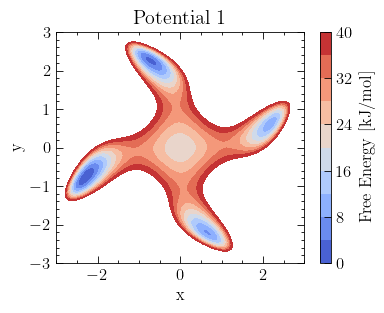

In [3]:
# Define the grid, the potential, the string of the potential and the FES cutoff
grid = np.linspace(-3, 3, 100); 
X, Y = np.meshgrid(grid, grid)
pot2 = 1.84*X**6 + 1.84*Y**6 - 11.5*X**4 - 11.5*Y**4 + 17.94*X**2 + 17.94*Y**2 - 2.3*X**5*Y + 2.3*X*Y**5 - 3.7*X**3*Y + 3.7*X*Y**3 + 20*X**2*Y**2 + 2.1*X**2 + 2.1*Y**2 + X**2*Y + X*Y**2 + 24.70075155
pot2 = pot2 - np.min(pot2)
dpot2_dy, dpot2_dx = np.gradient(pot2, grid, grid)
pot2_string = "1.84*x^6+1.84*y^6-11.5*x^4-11.5*y^4+17.94*x^2+17.94*y^2-2.3*x^5*y+2.3*x*y^5-3.7*x^3*y+3.7*x*y^3+20*x^2*y^2+2.1*x^2+2.1*y^2+x^2*y+x*y^2+24.70075155"
plumed_dat_text = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x,p.y FUNC=({pot2_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
FES_cutoff = 40

# Define plumed grid
[plX, plY, pl_min, pl_max, pl_n, pl_extra] = lib2.get_plumed_grid_2D(X, Y, [-4,-4], [4,4])

# plot the free energy surface
plt.contourf(X, Y, pot2, levels=np.linspace(0, FES_cutoff, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Potential 1"); plt.show()


In [4]:
# default parameters for the MFI class
default_params = {  "X":X, "Y":Y, "Z":pot2, "bw":[0.1, 0.1], #"dZ_dX":dpot2_dx, "dZ_dY":dpot2_dy,
                    "System":"Langevin", "plumed_dat_text":plumed_dat_text, "plX":plX, "plY":plY, "simulation_steps":3_000_000, 
                    "position_pace":20, "n_pos_per_window":10, "metad_pace":200, 
                    "metad_width":[0.1, 0.1], "metad_height":2, "biasfactor":20,
                    "Bias_sf":1, "gaus_filter_sigma":None,
                    "len_error_list":100,
                    "FES_cutoff":FES_cutoff, "calculate_FES_st_dev":False, "bootstrap_iter":50, "record_forces_e":True, "save_error_progression":False,
                    "simulation_folder_path": path_data, "print_info": False}

### Run 100 Long simulation for reference

In [12]:
os.chdir(path_notebook); reload(MFI_class2D); reload(lib2);

AAD = 2.0291675201317707


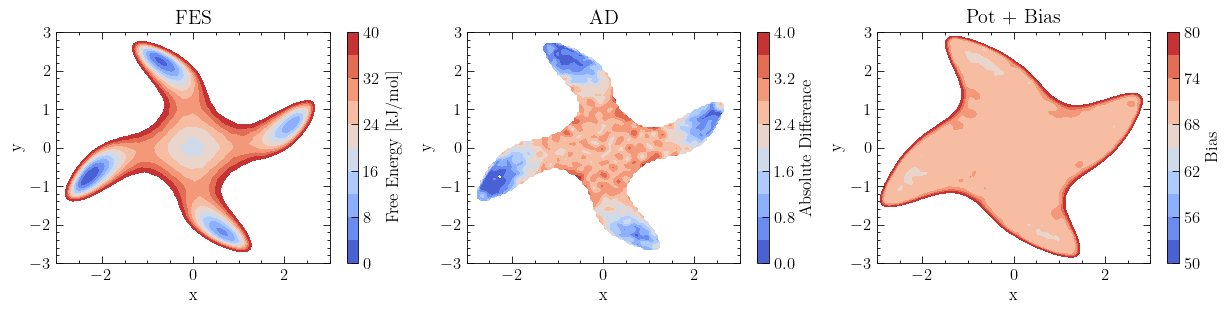

In [47]:
# plot MFI_long error
plt.figure(figsize=(15, 3))

fes = MFI_long.FES
ad = np.abs(fes - pot2) 
ad = np.where(pot2 > FES_cutoff, 0, ad)
print(f"AAD = {np.sum(ad)/(np.count_nonzero(ad))}")
bias_last = MFI_long.Bias

plt.subplot(1, 3, 1)
plt.contourf(X, Y, fes, levels=np.linspace(0, FES_cutoff, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("FES")

plt.subplot(1, 3, 2)
plt.contourf(X, Y, lib2.zero_to_nan(ad), levels=np.linspace(0, 4, 11), cmap='coolwarm'); plt.colorbar(label="Absolute Difference"); plt.xlabel("x"); plt.ylabel("y"); plt.title("AD")

plt.subplot(1, 3, 3)
plt.contourf(X, Y, pot2 + bias_last, levels=np.linspace(50, 80, 11), cmap='coolwarm'); plt.colorbar(label="Bias"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Pot + Bias"); 

In [16]:
# Run 100 long simulations
long_sim_params = {**default_params}
long_sim_params.update({"save_error_progression":True})#, "n_pos":50_000})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

for i_sim in range(1,21):
    
    sim_ID = f"_long_{i_sim}"
    long_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
    # if 1==2 and os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_long = MFI_class2D.MFI2D(**long_sim_params)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_long.run_simulation()
        MFI_long.analyse_data()
        t, aofe, aad, aBS = MFI_long.Avr_Error_list[:,0], MFI_long.Avr_Error_list[:,2], MFI_long.Avr_Error_list[:, MFI_long.aad_index], MFI_long.Avr_Error_list[:, MFI_long.abs_error_index]
        
        # MFI_long.plot_res()
        # lib2.plot_hills_trajectory(MFI_long.hills)
        
    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")


Simulation 1 (exists) | Final Error: Aofe = 0.8101, AAD = 2.3566, ABS = 0.8824
Simulation 2 (exists) | Final Error: Aofe = 0.8046, AAD = 1.8754, ABS = 0.8698
Simulation 3 (exists) | Final Error: Aofe = 0.8132, AAD = 2.4118, ABS = 0.8088
Simulation 4 (exists) | Final Error: Aofe = 0.8044, AAD = 2.2285, ABS = 0.7931
Simulation 5 (exists) | Final Error: Aofe = 0.8017, AAD = 1.9308, ABS = 0.8290
Simulation 6 (exists) | Final Error: Aofe = 0.8132, AAD = 2.5895, ABS = 0.8727
Simulation 7 (exists) | Final Error: Aofe = 0.8096, AAD = 2.6583, ABS = 0.9713
Simulation 8 (exists) | Final Error: Aofe = 0.8124, AAD = 2.0928, ABS = 0.8378
Simulation 9 (exists) | Final Error: Aofe = 0.8158, AAD = 2.6175, ABS = 0.8403
Simulation 10 (exists) | Final Error: Aofe = 0.8130, AAD = 2.1194, ABS = 0.8497
Simulation 11 (exists) | Final Error: Aofe = 0.8172, AAD = 2.6890, ABS = 0.7519
Simulation 12 (exists) | Final Error: Aofe = 0.8054, AAD = 1.9552, ABS = 0.6607
Simulation 13 (exists) | Final Error: Aofe = 0.81

Mean Final AAD: 2.2712 +- 0.0576 || Mean Final ABS: 0.8437 +- 0.0177


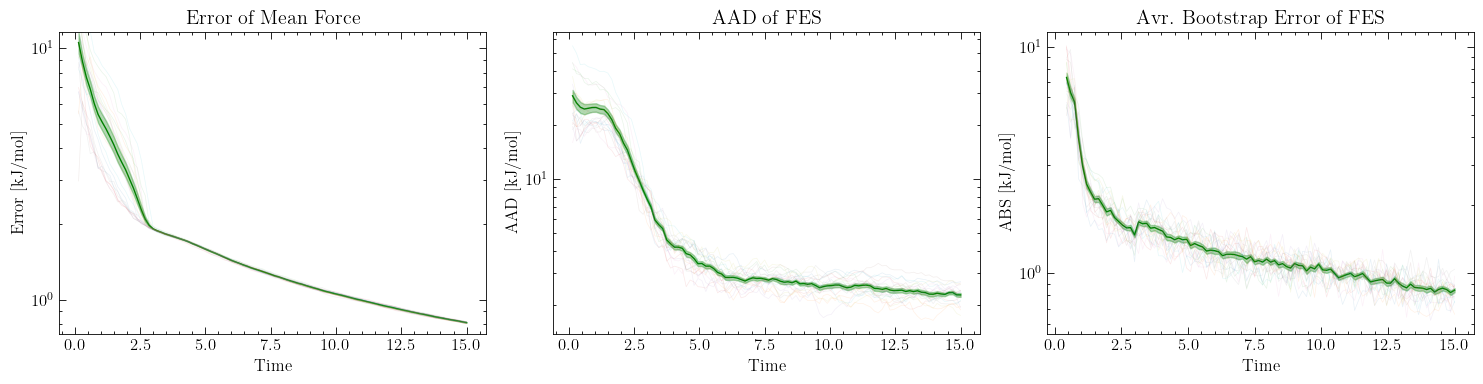

In [17]:
# Statistical Analysis of 100 long simulations
t_collection, aofe_collection, aad_collection, abs_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection), np.array(abs_collection)
t = t_collection[0]

avr_results = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection,
                                                                                                        return_results=True, plot=False, plot_log=True)
time_long, mean_ofe_long, ste_ofe_long, mean_aad_long, ste_aad_long, mean_abs_long, ste_abs_long = avr_results
plt.subplot(1,3,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,3)
for i in range(len(abs_collection)): plt.plot(t, abs_collection[i], linewidth=0.5, alpha=0.1)
# plt.ylim(0, 20)

print(f"Mean Final AAD: {mean_aad_long[-1]:.4f} +- {ste_aad_long[-1]:.4f} || Mean Final ABS: {mean_abs_long[-1]:.4f} +- {ste_abs_long[-1]:.4f}")
plt.show()


### Run 100 Exploration simulations

In [7]:
# Run 100 exploration simulations
expl_sim_params = {**default_params}
expl_sim_params.update({"save_error_progression":True})#, "n_pos":2_500})
expl_sim_params.update({"simulation_steps":300_000, "metad_height":10, "biasfactor":200, "len_error_list":25})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

for i_sim in range(1,101):
    
    sim_ID = f"_expl_{i_sim}"
    expl_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_expl = MFI_class2D.MFI2D(**expl_sim_params)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_expl.run_simulation()
        MFI_expl.analyse_data()
        t, aofe, aad, aBS = MFI_expl.Avr_Error_list[:,0], MFI_expl.Avr_Error_list[:,2], MFI_expl.Avr_Error_list[:, MFI_expl.aad_index], MFI_expl.Avr_Error_list[:, MFI_expl.abs_error_index]
        
        print(f"MIN(FES+Bias) = {np.min(MFI_expl.FES + MFI_expl.Bias):.4f}, MIN(Z+Bias) = {np.min(pot2 + MFI_expl.Bias):.4f}", end=" | ")
        # MFI_expl.plot_res()
        # lib2.plot_hills_trajectory(MFI_expl.hills)


    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")


Simulation 1 (exists) | 

ValueError: not enough values to unpack (expected 5, got 3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mean Final AAD: 3.0724 +- 0.0795


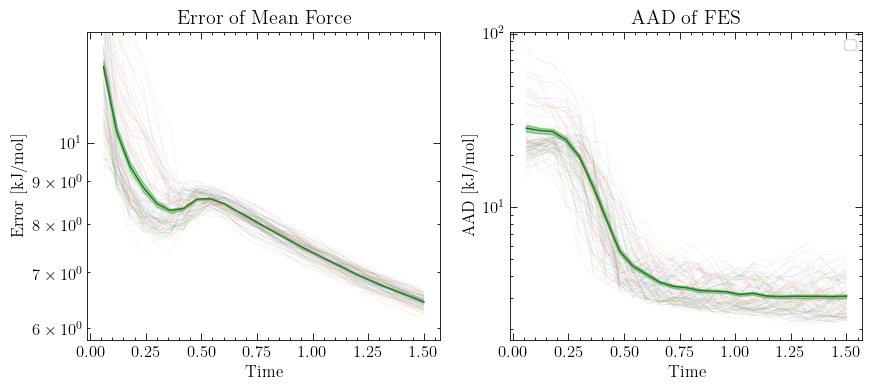

In [59]:
# Statistical Analysis of 100 exploration simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_expl, mean_ofe_expl, ste_ofe_expl, mean_aad_expl, ste_aad_expl = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=True)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)

print(f"Mean Final AAD: {mean_aad_expl[-1]:.4f} +- {ste_aad_expl[-1]:.4f}")

# plt.plot(t, aad_collection[88], label="run 88")
plt.legend(fontsize=10)
plt.show()


In [83]:
# # # Plot all exploration simulations to find a representative one to use for metad stage
# t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
# t = t_collection[0]

# for j in range(1, 21):
    
#     time_expl, mean_ofe_expl, ste_ofe_expl, mean_aad_expl, ste_aad_expl = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, return_results=True, plot=False, plot_log=False)
#     plt.subplot(1,2,1) 
#     for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
#     plt.subplot(1,2,2)
#     for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)    
    
#     for jj in range((j-1)*5, (j)*5):
        
#         print(f"Simulation {jj+1}", end=" | ")
        
#         plt.subplot(1,2,1)
#         plt.plot(t, aofe_collection[jj], label=f"{jj+1}", alpha=0.8)
#         plt.subplot(1,2,2)
#         plt.plot(t, aad_collection[jj], label=f"{jj+1}: {aad_collection[jj][-1]:.4f}", alpha=0.8)
    
#     print("")    
#     plt.legend(fontsize=10)
#     plt.yscale("log")
#     plt.show() 
                                                                                                        

Final Error: Aofe = 6.3978, AAD = 3.0584
MIN(FES+Bias) = 65.7034, MIN(Z+Bias) = 76.7243


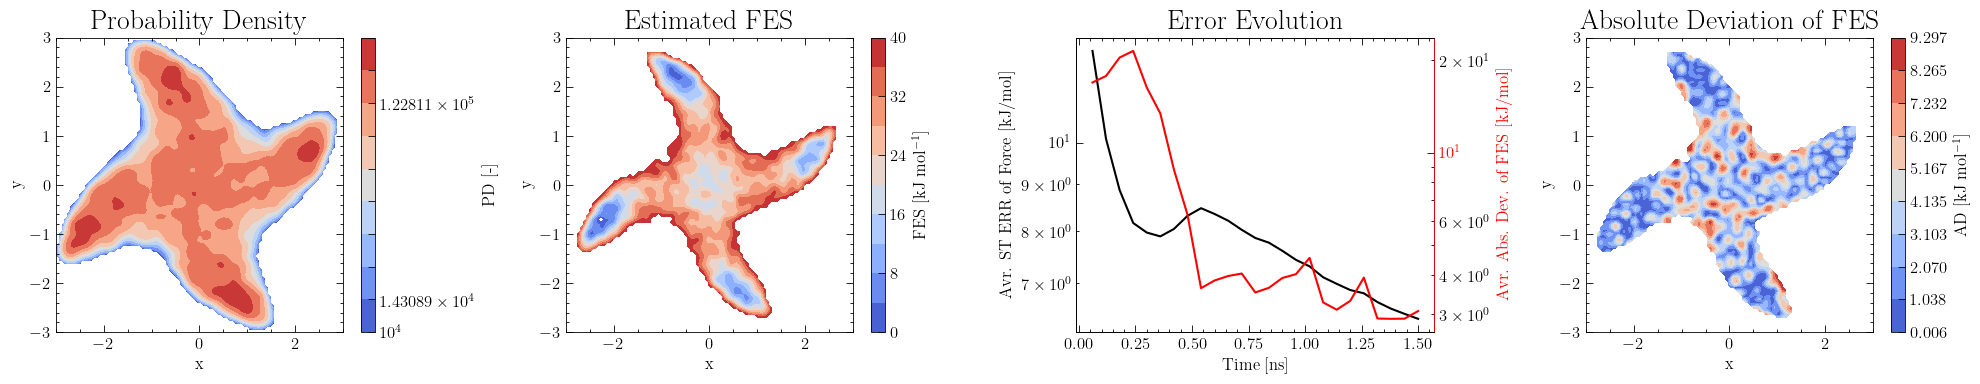

ready to show


In [5]:
# Exploration Simulation used for MetaD stage
new_params = {**default_params}
new_params.update({"ID":"_expl_44", "len_error_list":25, "save_results":True})

MFI_expl = MFI_class2D.MFI2D(**new_params)
MFI_expl.analyse_data()

print(F"Final Error: Aofe = {MFI_expl.Aofe:.4f}, AAD = {MFI_expl.AAD:.4f}")
print(f"MIN(FES+Bias) = {np.min(MFI_expl.FES + MFI_expl.Bias):.4f}, MIN(Z+Bias) = {np.min(pot2 + MFI_expl.Bias):.4f}")

MFI_expl.plot_res(["AD"])
lib2.plot_3D_plotly(MFI_expl.X, MFI_expl.Y, MFI_expl.Z + MFI_expl.Bias, range_min=0, range_max=np.min(pot2 + MFI_expl.Bias)*2)
t_expl, v_expl, aofe_expl, aad_expl, abs_expl = MFI_expl.Avr_Error_list[:,0], MFI_expl.Avr_Error_list[:,1], MFI_expl.Avr_Error_list[:,2], MFI_expl.Avr_Error_list[:, MFI_expl.aad_index], MFI_expl.Avr_Error_list[:, MFI_expl.abs_error_index]
force_terms_expl, sim_time_expl, fes_expl = MFI_expl.force_terms, MFI_expl.sim_time, MFI_expl.FES
forces_e_list_expl = MFI_expl.forces_e_list


### 2nd Stage - 1x MetaD simulation

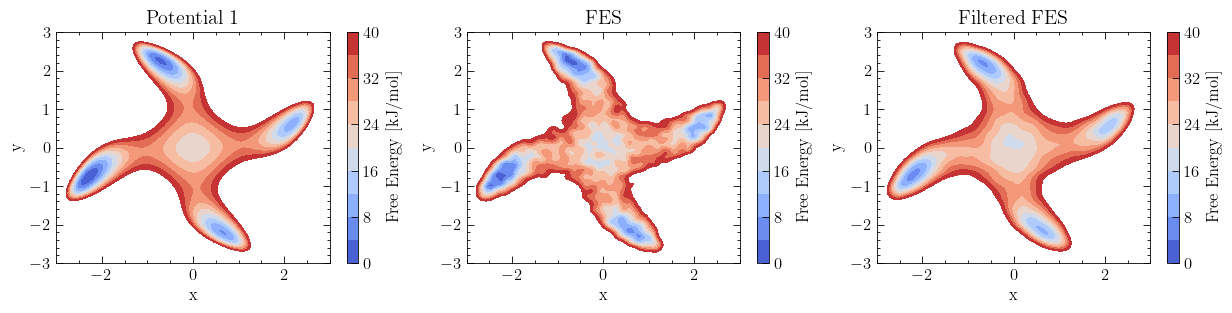

AAD FES: 2.8422
AAD FES_filtered: 2.8604


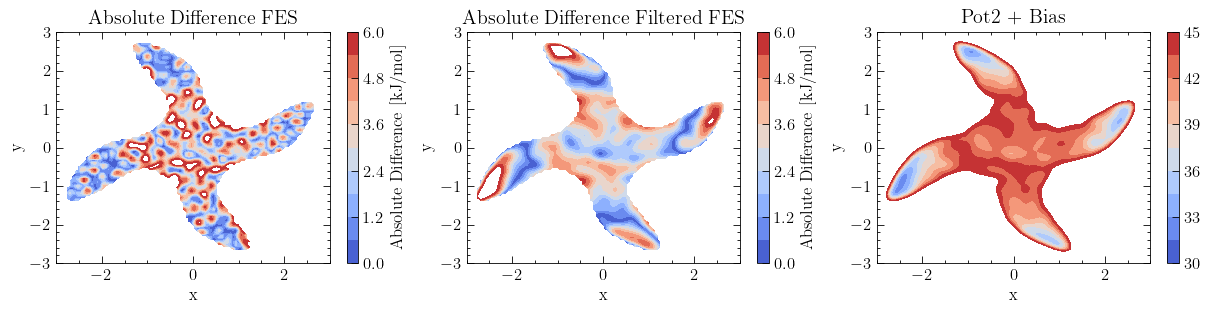

In [82]:
# plot potential, FES, filered FES, AD, AAD, AD_filtered, AAD_filtered, Bias+Pot
from scipy.ndimage import gaussian_filter
gfs = 2

fes = MFI_expl.FES
fes_filered = gaussian_filter(fes, sigma=gfs)

for _plot_ in [1]:
    plt.figure(figsize=(15,3))
    plt.subplot(1,3,1)
    plt.contourf(X, Y, pot2, levels=np.linspace(0, 40, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Potential 1")

    plt.subplot(1,3,2)
    plt.contourf(X, Y, fes, levels=np.linspace(0, 40, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("FES")

    plt.subplot(1,3,3)
    plt.contourf(X, Y, fes_filered, levels=np.linspace(0, 40, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Filtered FES")
    plt.show()

    plt.figure(figsize=(15,3))
    ad_fes = np.where(pot2 <= 40, np.abs(fes - pot2), 0)
    print(f"AAD FES: {np.sum(ad_fes)/(np.count_nonzero(ad_fes)):.4f}")
    plt.subplot(1,3,1)
    plt.contourf(X, Y, lib2.zero_to_nan(ad_fes), levels=np.linspace(0, 6, 11), cmap='coolwarm'); plt.colorbar(label="Absolute Difference [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Absolute Difference FES")

    ad_fes_filtered = np.where(pot2 <= 40, np.abs(fes_filered - pot2), 0)
    print(f"AAD FES_filtered: {np.sum(ad_fes_filtered)/(np.count_nonzero(ad_fes)):.4f}")

    plt.subplot(1,3,2)
    plt.contourf(X, Y, lib2.zero_to_nan(ad_fes_filtered), levels=np.linspace(0, 6, 11), cmap='coolwarm'); plt.colorbar(label="Absolute Difference [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Absolute Difference Filtered FES")
    
    bias, fx_bias, fy_bias, file_path_dat = lib2.make_external_bias_2D(X, Y, FES=fes, Bias_sf=1, gaus_filter_sigma=gfs, FES_cutoff=40, return_array=True)

    
    plt.subplot(1,3,3)
    plt.contourf(X, Y, pot2+bias, levels=np.linspace(30, 45, 11), cmap='coolwarm'); plt.colorbar(label=""); plt.xlabel("x"); plt.ylabel("y"); plt.title("Pot2 + Bias")
    plt.show()

In [ ]:
## laod results from the exploration simulation
res = lib2.load_pkl(path_data + f"MFI_results_expl_44.pkl")[1]
force_terms_expl = res[0]
fes_expl = lib2.FFT_intg_2D(force_terms_expl[2], force_terms_expl[3], [-3,-3], [3, 3])
sim_time_expl = res[1].T[0][-1]
forces_e_list_expl = res[-1]


In [11]:
# Run 100 MetaD simulations
metad_sim_params = {**default_params}
metad_sim_params.update({"simulation_steps":2_700_000, "save_error_progression":True, "save_results":True})
metad_sim_params.update({"metad_height":2, "biasfactor":5, "gaus_filter_sigma":2})
metad_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl, "base_forces_e_list":forces_e_list_expl})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

for i_sim in range(1, 101):
    
    sim_ID = f"_metad_{i_sim}"
    metad_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
    # if 1==2 and os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
        
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_metad = MFI_class2D.MFI2D(**metad_sim_params)
        MFI_metad.make_external_bias(FES=fes_expl)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_metad.run_simulation()
        MFI_metad.analyse_data()
        t, aofe, aad, aBS = MFI_metad.Avr_Error_list[:,0], MFI_metad.Avr_Error_list[:,2], MFI_metad.Avr_Error_list[:, MFI_metad.aad_index], MFI_metad.Avr_Error_list[:, MFI_metad.abs_error_index]
        
        # MFI_metad.plot_res()
        # lib2.plot_hills_trajectory(MFI_metad.hills)

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")


Simulation 1 (exists) | Final Error: Aofe = 1.0970, AAD = 3.4525, ABS = 0.9674
Simulation 2 (exists) | Final Error: Aofe = 1.0945, AAD = 3.5096, ABS = 0.8713
Simulation 3 (exists) | Final Error: Aofe = 1.0927, AAD = 3.4611, ABS = 0.9102
Simulation 4 (exists) | Final Error: Aofe = 1.0896, AAD = 3.2263, ABS = 0.8445
Simulation 5 (exists) | Final Error: Aofe = 1.0962, AAD = 3.4791, ABS = 0.8952
Simulation 6 (exists) | Final Error: Aofe = 1.0910, AAD = 3.4708, ABS = 0.8652
Simulation 7 (exists) | Final Error: Aofe = 1.0990, AAD = 3.5364, ABS = 0.9205
Simulation 8 (exists) | Final Error: Aofe = 1.0896, AAD = 3.5883, ABS = 0.7453
Simulation 9 (exists) | Final Error: Aofe = 1.0931, AAD = 3.4295, ABS = 0.8519
Simulation 10 (exists) | Final Error: Aofe = 1.0946, AAD = 3.1541, ABS = 0.9181
Simulation 11 (exists) | Final Error: Aofe = 1.1065, AAD = 3.4113, ABS = 0.8637
Simulation 12 (exists) | Final Error: Aofe = 1.0977, AAD = 3.6277, ABS = 0.9344
Simulation 13 (exists) | Final Error: Aofe = 1.10

Mean Final AAD: 3.4758 +- 0.0137 || Mean Final ABS: 0.8672 +- 0.0067


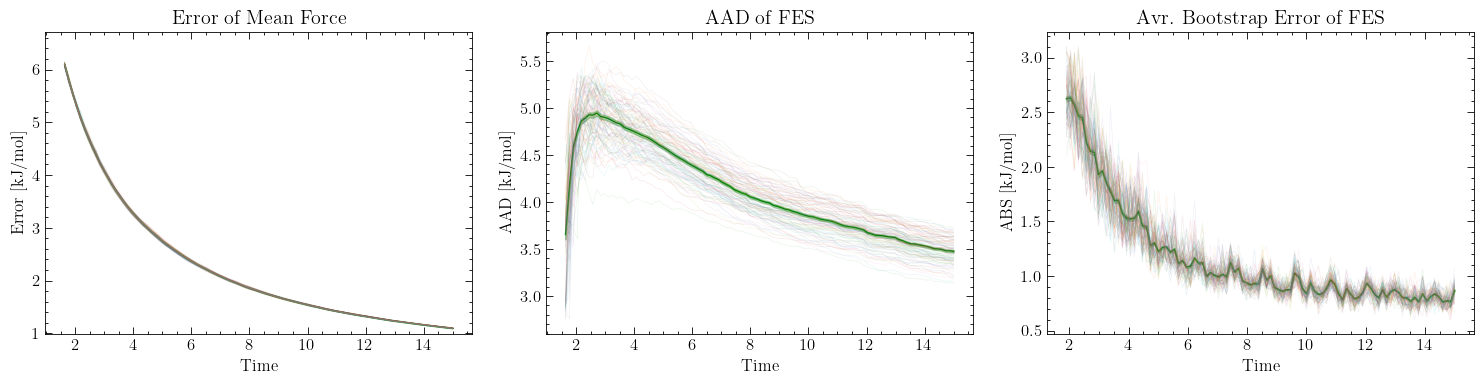

In [12]:
# Statistical Analysis of 100 MetaD simulations
t_collection, aofe_collection, aad_collection, abs_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection), np.array(abs_collection)
t = t_collection[0]

avr_results = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection, 
                                                return_results=True, plot=False, plot_log=False)
time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad, mean_abs_metad, ste_abs_metad = avr_results

plt.subplot(1,3,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,3)
for i in range(len(abs_collection)): plt.plot(t, abs_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metad[-1]:.4f} +- {ste_aad_metad[-1]:.4f} || Mean Final ABS: {mean_abs_metad[-1]:.4f} +- {ste_abs_metad[-1]:.4f}")
plt.show()

In [13]:
# Run 100 MetaD ALTERNATIVE simulations
metad_sim_params = {**default_params}
metad_sim_params.update({"simulation_steps":2_700_000, "save_error_progression":True, "save_results":True})
metad_sim_params.update({"metad_height":2, "biasfactor":5, "gaus_filter_sigma":2})
metad_sim_params.update({"base_forces":None, "base_time":sim_time_expl, "base_forces_e_list":None})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

for i_sim in range(1, 101):
    
    sim_ID = f"_metad_{i_sim}"
    sim_ID_ALT = f"_metad_ALT_{i_sim}"
    metad_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID_ALT}.pkl"):
    # if 1==2 and os.path.isfile(path_data + f"error_progression{sim_ID_ALT}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{sim_ID_ALT}.pkl")
        
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_metad = MFI_class2D.MFI2D(**metad_sim_params)
        MFI_metad.make_external_bias(FES=fes_expl)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_metad.run_simulation()
        MFI_metad.ID = sim_ID_ALT
        MFI_metad.analyse_data()
        t, aofe, aad, aBS = MFI_metad.Avr_Error_list[:,0], MFI_metad.Avr_Error_list[:,2], MFI_metad.Avr_Error_list[:, MFI_metad.aad_index], MFI_metad.Avr_Error_list[:, MFI_metad.abs_error_index]
        
        # MFI_metad.plot_res()
        # lib2.plot_hills_trajectory(MFI_metad.hills)

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")


Simulation 1 (exists) | Final Error: Aofe = 0.6205, AAD = 0.7592, ABS = 0.2764
Simulation 2 (exists) | Final Error: Aofe = 0.6306, AAD = 1.3036, ABS = 0.2355
Simulation 3 (exists) | Final Error: Aofe = 0.6220, AAD = 1.0785, ABS = 0.3136
Simulation 4 (exists) | Final Error: Aofe = 0.6198, AAD = 0.9428, ABS = 0.2471
Simulation 5 (exists) | Final Error: Aofe = 0.6237, AAD = 1.0373, ABS = 0.3232
Simulation 6 (exists) | Final Error: Aofe = 0.6236, AAD = 1.1501, ABS = 0.2302
Simulation 7 (exists) | Final Error: Aofe = 0.6312, AAD = 1.2505, ABS = 0.2540
Simulation 8 (exists) | Final Error: Aofe = 0.6247, AAD = 1.3123, ABS = 0.2861
Simulation 9 (exists) | Final Error: Aofe = 0.6234, AAD = 0.9743, ABS = 0.2739
Simulation 10 (exists) | Final Error: Aofe = 0.6256, AAD = 0.9065, ABS = 0.2831
Simulation 11 (exists) | Final Error: Aofe = 0.6307, AAD = 0.9285, ABS = 0.2128
Simulation 12 (exists) | Final Error: Aofe = 0.6212, AAD = 1.0935, ABS = 0.2765
Simulation 13 (exists) | Final Error: Aofe = 0.63

Mean Final AAD: 1.0930 +- 0.0155  || Mean Final ABS: 0.2721 +- 0.0040


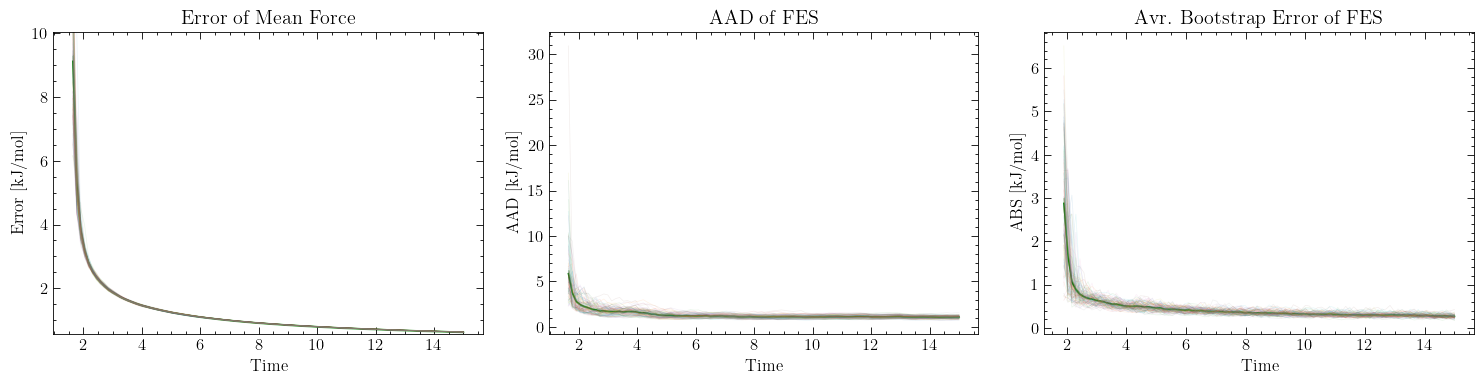

In [14]:
# Statistical Analysis of 100 MetaD ALTERNATIVE simulations
t_collection, aofe_collection, aad_collection, abs_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection), np.array(abs_collection)
t = t_collection[0]

avr_results = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection,
                                                return_results=True, plot=False, plot_log=False)
time_metadALT, mean_ofe_metadALT, ste_ofe_metadALT, mean_aad_metadALT, ste_aad_metadALT, mean_abs_metadALT, ste_abs_metadALT = avr_results
plt.subplot(1,3,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,3)
for i in range(len(abs_collection)): plt.plot(t, abs_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadALT[-1]:.4f} +- {ste_aad_metadALT[-1]:.4f}  || Mean Final ABS: {mean_abs_metadALT[-1]:.4f} +- {ste_abs_metadALT[-1]:.4f}")
plt.show()

### 2nd Stage - 2x MetaD simulations

In [25]:
# Patching of 50x2 MetaD simulations
metadx2_sim_params = {**default_params}
metadx2_sim_params.update({"simulation_steps":750_000, "len_error_list":360})#, "n_pos":35_625}) # 
metadx2_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl, "base_forces_e_list":forces_e_list_expl})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

n_parallel = 2
parallel_efficiency = 0.75

for n_camp in range(1, 51):
    
    camp_ID = f"_metadx2_{n_camp}"
    metadx2_sim_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx2 = MFI_class2D.MFI2D(**metadx2_sim_params)
        MFI_metadx2.make_external_bias(FES=fes_expl)
        mfi_parallel_x2 = MFI_metadx2.MFI_parallel(parent=MFI_metadx2, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x2.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x2.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x2.patch_simulations()
        t, v, aofe, aad, aBS = MFI_metadx2.Avr_Error_list[:,0], MFI_metadx2.Avr_Error_list[:,1], MFI_metadx2.Avr_Error_list[:,2], MFI_metadx2.Avr_Error_list[:, MFI_metadx2.aad_index], MFI_metadx2.Avr_Error_list[:, MFI_metadx2.abs_error_index]
        lib2.save_pkl(np.array([t, v, aofe, aad, aBS]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)      
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")


Analysis 1 (exists) | Final Error: Aofe = 0.8332, AAD = 3.5265, ABS = 0.7587
Analysis 2 (exists) | Final Error: Aofe = 0.8263, AAD = 3.3739, ABS = 0.7570
Analysis 3 (exists) | Final Error: Aofe = 0.8345, AAD = 3.4771, ABS = 0.6786
Analysis 4 (exists) | Final Error: Aofe = 0.8330, AAD = 3.5308, ABS = 0.7289
Analysis 5 (exists) | Final Error: Aofe = 0.8300, AAD = 3.3289, ABS = 0.5736
Analysis 6 (exists) | Final Error: Aofe = 0.8319, AAD = 3.6188, ABS = 0.7755
Analysis 7 (exists) | Final Error: Aofe = 0.8302, AAD = 3.5572, ABS = 0.7306
Analysis 8 (exists) | Final Error: Aofe = 0.8384, AAD = 3.4913, ABS = 0.6796
Analysis 9 (exists) | Final Error: Aofe = 0.8314, AAD = 3.3011, ABS = 0.7095
Analysis 10 (exists) | Final Error: Aofe = 0.8340, AAD = 3.3948, ABS = 0.8148
Analysis 11 (exists) | Final Error: Aofe = 0.8309, AAD = 3.5515, ABS = 0.7293
Analysis 12 (exists) | Final Error: Aofe = 0.8291, AAD = 3.4193, ABS = 0.7433
Analysis 13 (exists) | Final Error: Aofe = 0.8347, AAD = 3.6047, ABS = 0.

Mean Final AAD: 3.5195 +- 0.0153 || Mean Final ABS: 0.7176 +- 0.0086


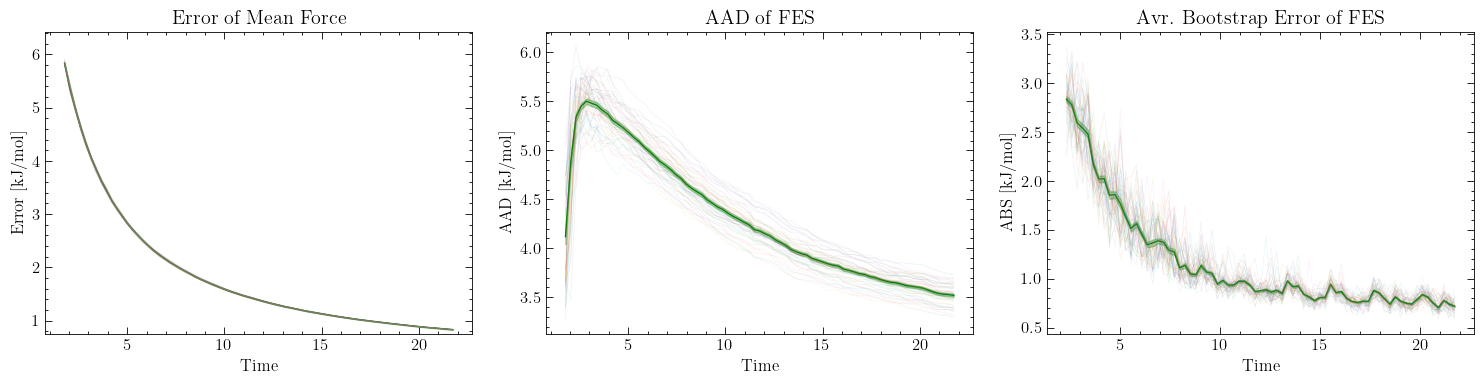

In [26]:
# Statistical Analysis of 50x2 MetaD simulations
t_collection, aofe_collection, aad_collection, abs_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection), np.array(abs_collection)
t = t_collection[0]

avr_results = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection,
                                                return_results=True, plot=False, plot_log=False)
time_metadx2, mean_ofe_metadx2, ste_ofe_metadx2, mean_aad_metadx2, ste_aad_metadx2, mean_abs_metadx2, ste_abs_metadx2 = avr_results
plt.subplot(1,3,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,3)
for i in range(len(abs_collection)): plt.plot(t, abs_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx2[-1]:.4f} +- {ste_aad_metadx2[-1]:.4f} || Mean Final ABS: {mean_abs_metadx2[-1]:.4f} +- {ste_abs_metadx2[-1]:.4f}")
plt.show()

In [27]:
# Patching of 50x2 MetaD simulations
metadx2_sim_params = {**default_params}
metadx2_sim_params.update({"simulation_steps":750_000, "len_error_list":360})#, "n_pos":35_625}) # 
metadx2_sim_params.update({"base_forces":None, "base_time":sim_time_expl, "base_forces_e_list":None})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

n_parallel = 2
parallel_efficiency = 0.75

for n_camp in range(1, 51):
    
    camp_ID = f"_metadx2ALT_{n_camp}"
    metadx2_sim_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx2 = MFI_class2D.MFI2D(**metadx2_sim_params)
        MFI_metadx2.make_external_bias(FES=fes_expl)
        mfi_parallel_x2 = MFI_metadx2.MFI_parallel(parent=MFI_metadx2, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x2.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x2.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x2.patch_simulations()
        t, v, aofe, aad, aBS = MFI_metadx2.Avr_Error_list[:,0], MFI_metadx2.Avr_Error_list[:,1], MFI_metadx2.Avr_Error_list[:,2], MFI_metadx2.Avr_Error_list[:, MFI_metadx2.aad_index], MFI_metadx2.Avr_Error_list[:, MFI_metadx2.abs_error_index]
        lib2.save_pkl(np.array([t, v, aofe, aad, aBS]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)      
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")


Analysis 1 (exists) | Final Error: Aofe = 0.5344, AAD = 1.0768, ABS = 0.2489
Analysis 2 (exists) | Final Error: Aofe = 0.5290, AAD = 1.1063, ABS = 0.2771
Analysis 3 (exists) | Final Error: Aofe = 0.5352, AAD = 1.0733, ABS = 0.3085
Analysis 4 (exists) | Final Error: Aofe = 0.5365, AAD = 1.2245, ABS = 0.2341
Analysis 5 (exists) | Final Error: Aofe = 0.5306, AAD = 1.0094, ABS = 0.2834
Analysis 6 (exists) | Final Error: Aofe = 0.5306, AAD = 1.1700, ABS = 0.2222
Analysis 7 (exists) | Final Error: Aofe = 0.5337, AAD = 1.5292, ABS = 0.2870
Analysis 8 (exists) | Final Error: Aofe = 0.5361, AAD = 0.9843, ABS = 0.2463
Analysis 9 (exists) | Final Error: Aofe = 0.5286, AAD = 0.7888, ABS = 0.2105
Analysis 10 (exists) | Final Error: Aofe = 0.5361, AAD = 1.0390, ABS = 0.2385
Analysis 11 (exists) | Final Error: Aofe = 0.5340, AAD = 1.2161, ABS = 0.2815
Analysis 12 (exists) | Final Error: Aofe = 0.5310, AAD = 1.0400, ABS = 0.2239
Analysis 13 (exists) | Final Error: Aofe = 0.5342, AAD = 1.2756, ABS = 0.

Mean Final AAD: 3.5195 +- 0.0153 || Mean Final ABS: 0.7176 +- 0.0086


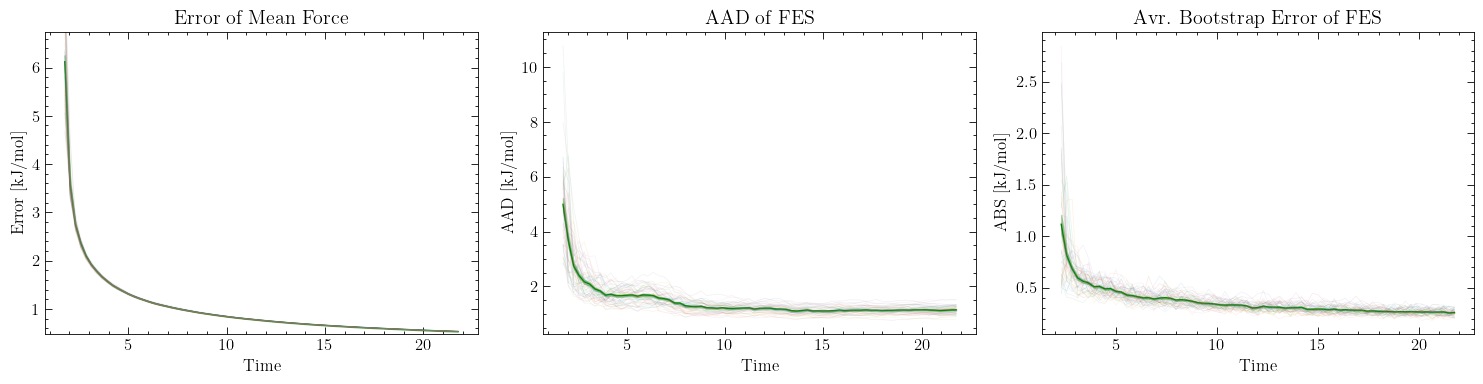

In [28]:
# Statistical Analysis of 50x2 MetaD simulations
t_collection, aofe_collection, aad_collection, abs_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection), np.array(abs_collection)
t = t_collection[0]

avr_results = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection,
                                                return_results=True, plot=False, plot_log=False)
time_metadx2ALT, mean_ofe_metadx2ALT, ste_ofe_metadx2ALT, mean_aad_metadx2ALT, ste_aad_metadx2ALT, mean_abs_metadx2ALT, ste_abs_metadx2ALT = avr_results
plt.subplot(1,3,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,3)
for i in range(len(abs_collection)): plt.plot(t, abs_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx2[-1]:.4f} +- {ste_aad_metadx2[-1]:.4f} || Mean Final ABS: {mean_abs_metadx2[-1]:.4f} +- {ste_abs_metadx2[-1]:.4f}")
plt.show()

### 2nd Stage - 3x MetaD simulations

In [13]:
# Patching of 33x3 MetaD simulations
metadx3_sim_params = {**default_params}
metadx3_sim_params.update({"simulation_steps":633_333, "len_error_list":320})#, "n_pos":31_667}) # 
metadx3_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 3
parallel_efficiency = 0.667

for n_camp in range(1, 34):
    
    camp_ID = f"_metadx3_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx3 = MFI_class2D.MFI2D(**metadx3_sim_params)
        MFI_metadx3.make_external_bias(FES=fes_expl)
        mfi_parallel_x3 = MFI_metadx3.MFI_parallel(parent=MFI_metadx3, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x3.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x3.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x3.patch_simulations()
        t, aofe, aad = MFI_metadx3.Avr_Error_list[:,0], MFI_metadx3.Avr_Error_list[:,2], MFI_metadx3.Avr_Error_list[:, MFI_metadx3.aad_index]
        lib2.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 (exists) | Final Error: Aofe = 0.7649, AAD = 0.3898
Analysis 2 (exists) | Final Error: Aofe = 0.7678, AAD = 0.4800
Analysis 3 (exists) | Final Error: Aofe = 0.7644, AAD = 0.4179
Analysis 4 (exists) | Final Error: Aofe = 0.7673, AAD = 0.3839
Analysis 5 (exists) | Final Error: Aofe = 0.7636, AAD = 0.3980
Analysis 6 (exists) | Final Error: Aofe = 0.7652, AAD = 0.4419
Analysis 7 (exists) | Final Error: Aofe = 0.7678, AAD = 0.3718
Analysis 8 (exists) | Final Error: Aofe = 0.7680, AAD = 0.4297
Analysis 9 (exists) | Final Error: Aofe = 0.7684, AAD = 0.4068
Analysis 10 (exists) | Final Error: Aofe = 0.7669, AAD = 0.4369
Analysis 11 (exists) | Final Error: Aofe = 0.7675, AAD = 0.4047
Analysis 12 (exists) | Final Error: Aofe = 0.7688, AAD = 0.5875
Analysis 13 (exists) | Final Error: Aofe = 0.7686, AAD = 0.3938
Analysis 14 (exists) | Final Error: Aofe = 0.7679, AAD = 0.4078
Analysis 15 (exists) | Final Error: Aofe = 0.7666, AAD = 0.4092
Analysis 16 (exists) | Final Error: Aofe = 0.7656

Mean Final AAD: 0.4193 +- 0.0073


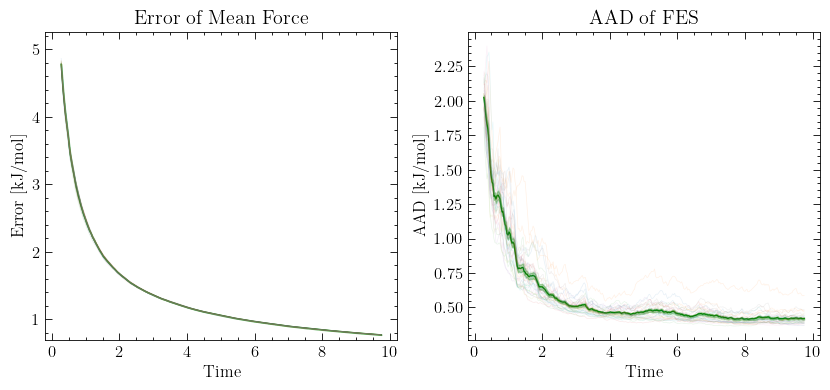

In [14]:
# Statistical Analysis of 33x3 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx3, mean_ofe_metadx3, ste_ofe_metadx3, mean_aad_metadx3, ste_aad_metadx3 = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx3[-1]:.4f} +- {ste_aad_metadx3[-1]:.4f}")
plt.show()

### 2nd Stage - 4x MetaD simulations

In [15]:
# Patching of 25x4 MetaD simulations
metadx4_sim_params = {**default_params}
# metadx4_sim_params.update({"simulation_steps":633_333, "len_error_list":320})#, "n_pos":31_667}) # 
metadx4_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 4
parallel_efficiency = 0.5

for n_camp in range(1, 26):
    
    camp_ID = f"_metadx4_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx4 = MFI_class2D.MFI2D(**metadx4_sim_params)
        MFI_metadx4.make_external_bias(FES=fes_expl)
        mfi_parallel_x4 = MFI_metadx4.MFI_parallel(parent=MFI_metadx4, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x4.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x4.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x4.patch_simulations()
        t, aofe, aad = MFI_metadx4.Avr_Error_list[:,0], MFI_metadx4.Avr_Error_list[:,2], MFI_metadx4.Avr_Error_list[:, MFI_metadx4.aad_index]
        lib2.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")



Analysis 1 (exists) | Final Error: Aofe = 0.7578, AAD = 0.4426
Analysis 2 (exists) | Final Error: Aofe = 0.7598, AAD = 0.4279
Analysis 3 (exists) | Final Error: Aofe = 0.7595, AAD = 0.3953
Analysis 4 (exists) | Final Error: Aofe = 0.7548, AAD = 0.4275
Analysis 5 (exists) | Final Error: Aofe = 0.7582, AAD = 0.4129
Analysis 6 (exists) | Final Error: Aofe = 0.7624, AAD = 0.3865
Analysis 7 (exists) | Final Error: Aofe = 0.7571, AAD = 0.3914
Analysis 8 (exists) | Final Error: Aofe = 0.7584, AAD = 0.4030
Analysis 9 (exists) | Final Error: Aofe = 0.7598, AAD = 0.5444
Analysis 10 (exists) | Final Error: Aofe = 0.7583, AAD = 0.4012
Analysis 11 (exists) | Final Error: Aofe = 0.7617, AAD = 0.4234
Analysis 12 (exists) | Final Error: Aofe = 0.7580, AAD = 0.4215
Analysis 13 (exists) | Final Error: Aofe = 0.7568, AAD = 0.3936
Analysis 14 (exists) | Final Error: Aofe = 0.7612, AAD = 0.4003
Analysis 15 (exists) | Final Error: Aofe = 0.7571, AAD = 0.4410
Analysis 16 (exists) | Final Error: Aofe = 0.7547

Mean Final AAD: 0.4115 +- 0.0069


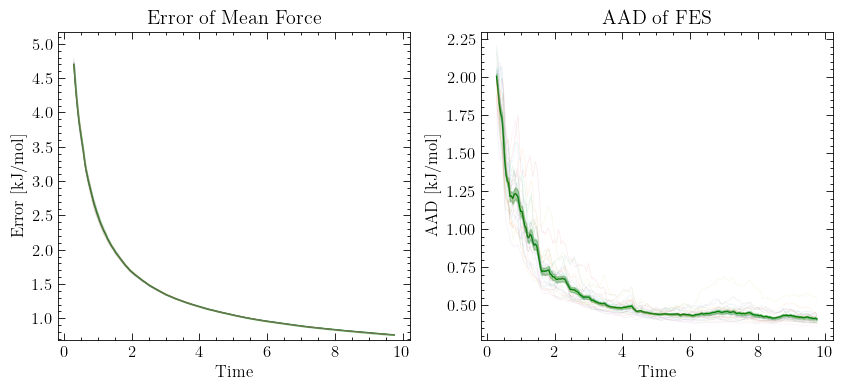

In [16]:
# Statistical Analysis of 25x4 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx4, mean_ofe_metadx4, ste_ofe_metadx4, mean_aad_metadx4, ste_aad_metadx4 = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx4[-1]:.4f} +- {ste_aad_metadx4[-1]:.4f}")
plt.show()

### 2nd Stage 6x MetaD simulation

In [17]:
# Patching of 16x6 MetaD simulations
metadx6_sim_params = {**default_params}
# metadx6_sim_params.update({"simulation_steps":633_333, "len_error_list":320})#, "n_pos":31_667}) # 
metadx6_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 6
parallel_efficiency = 0.4

for n_camp in range(1, 17):
    
    camp_ID = f"_metadx6_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx6 = MFI_class2D.MFI2D(**metadx6_sim_params)
        MFI_metadx6.make_external_bias(FES=fes_expl)
        mfi_parallel_x6 = MFI_metadx6.MFI_parallel(parent=MFI_metadx6, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x6.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x6.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x6.patch_simulations()
        t, aofe, aad = MFI_metadx6.Avr_Error_list[:,0], MFI_metadx6.Avr_Error_list[:,2], MFI_metadx6.Avr_Error_list[:, MFI_metadx6.aad_index]
        lib2.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 (exists) | Final Error: Aofe = 0.6889, AAD = 0.4595
Analysis 2 (exists) | Final Error: Aofe = 0.6884, AAD = 0.4704
Analysis 3 (exists) | Final Error: Aofe = 0.6851, AAD = 0.3912
Analysis 4 (exists) | Final Error: Aofe = 0.6923, AAD = 0.4045
Analysis 5 (exists) | Final Error: Aofe = 0.6876, AAD = 0.4200
Analysis 6 (exists) | Final Error: Aofe = 0.6892, AAD = 0.5372
Analysis 7 (exists) | Final Error: Aofe = 0.6896, AAD = 0.4487
Analysis 8 (exists) | Final Error: Aofe = 0.6875, AAD = 0.4302
Analysis 9 (exists) | Final Error: Aofe = 0.6904, AAD = 0.4136
Analysis 10 (exists) | Final Error: Aofe = 0.6872, AAD = 0.4088
Analysis 11 (exists) | Final Error: Aofe = 0.6864, AAD = 0.4455
Analysis 12 (exists) | Final Error: Aofe = 0.6910, AAD = 0.3746
Analysis 13 (exists) | Final Error: Aofe = 0.6894, AAD = 0.3840
Analysis 14 (exists) | Final Error: Aofe = 0.6885, AAD = 0.4054
Analysis 15 (exists) | Final Error: Aofe = 0.6884, AAD = 0.3925
Analysis 16 (exists) | Final Error: Aofe = 0.6854

Mean Final AAD: 0.4266 +- 0.0098


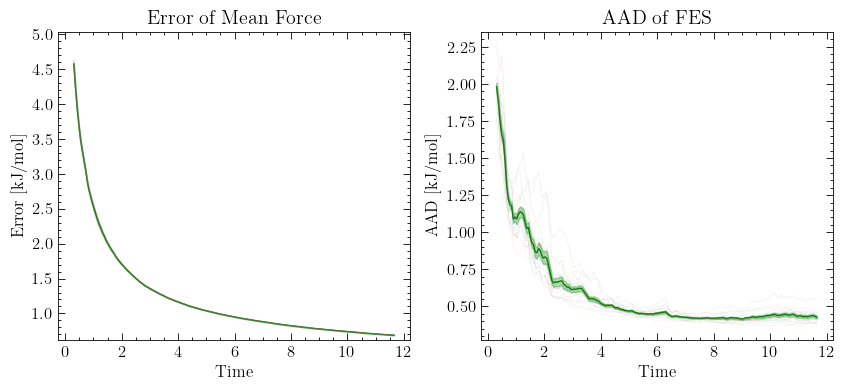

In [18]:
# Statistical Analysis of 16x6 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx6, mean_ofe_metadx6, ste_ofe_metadx6, mean_aad_metadx6, ste_aad_metadx6 = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx6[-1]:.4f} +- {ste_aad_metadx6[-1]:.4f}")
plt.show()

### 2nd Stage 10x MetaD simulation

In [19]:
# Patching of 10x10 MetaD simulations
metadx10_sim_params = {**default_params}
# metadx10_sim_params.update({"simulation_steps":633_333, "len_error_list":320})#, "n_pos":31_667}) # 
metadx10_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 10
parallel_efficiency = 0.3

for n_camp in range(1, 11):
    
    camp_ID = f"_metadx10_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx10 = MFI_class2D.MFI2D(**metadx10_sim_params)
        MFI_metadx10.make_external_bias(FES=fes_expl)
        mfi_parallel_x10 = MFI_metadx10.MFI_parallel(parent=MFI_metadx10, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x10.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x10.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x10.patch_simulations()
        t, aofe, aad = MFI_metadx10.Avr_Error_list[:,0], MFI_metadx10.Avr_Error_list[:,2], MFI_metadx10.Avr_Error_list[:, MFI_metadx10.aad_index]
        lib2.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 (exists) | Final Error: Aofe = 0.6115, AAD = 0.4377
Analysis 2 (exists) | Final Error: Aofe = 0.6096, AAD = 0.3990
Analysis 3 (exists) | Final Error: Aofe = 0.6105, AAD = 0.3979
Analysis 4 (exists) | Final Error: Aofe = 0.6114, AAD = 0.4074
Analysis 5 (exists) | Final Error: Aofe = 0.6133, AAD = 0.4414
Analysis 6 (exists) | Final Error: Aofe = 0.6107, AAD = 0.3878
Analysis 7 (exists) | Final Error: Aofe = 0.6110, AAD = 0.3828
Analysis 8 (exists) | Final Error: Aofe = 0.6139, AAD = 0.3802
Analysis 9 (exists) | Final Error: Aofe = 0.6112, AAD = 0.3913
Analysis 10 (exists) | Final Error: Aofe = 0.6113, AAD = 0.3948


Mean Final AAD: 0.4020 +- 0.0064


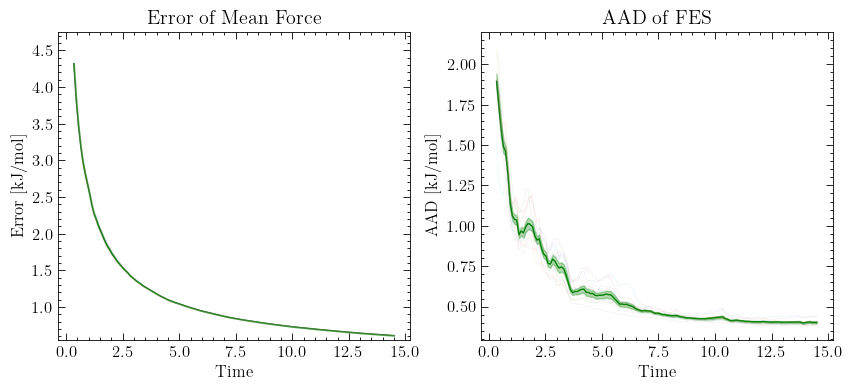

In [20]:
# Statistical Analysis of 10x10 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx10, mean_ofe_metadx10, ste_ofe_metadx10, mean_aad_metadx10, ste_aad_metadx10 = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx10[-1]:.4f} +- {ste_aad_metadx10[-1]:.4f}")
plt.show()

### Compare Convergence of Simulations

In [21]:
# import gaussian_filter
from scipy.signal import savgol_filter

def sf(data, window_length=None, polyorder=None):
    # if window_length is None: window_length = int(len(data)/10)
    # if polyorder is None: polyorder = 2
    # return savgol_filter(data, window_length, polyorder)
    return data


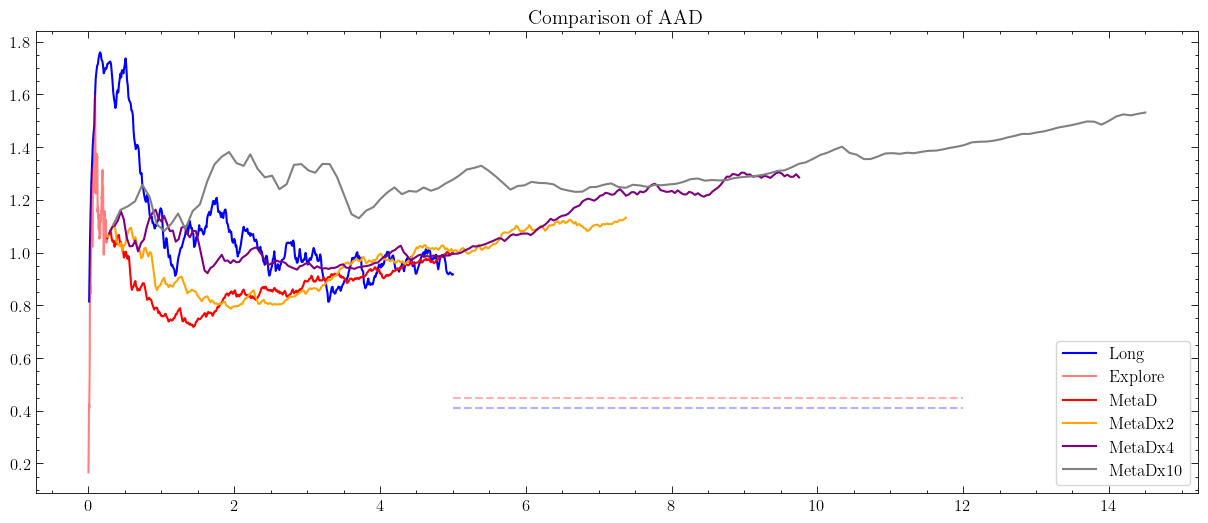

In [22]:
plt.figure(figsize=(15,6))
# plt.figure(figsize=(20,4))
# # time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad

# plt.subplot(1,2,1)
# plt.plot(time_long, mean_ofe_long, label="Long", color="blue")
# # plt.plot(time_expl, mean_ofe_expl, label="Explore", color="red", alpha=0.5)
# plt.plot(t_expl, aofe_expl, label="Explore", color="red", alpha=0.5)
# plt.plot(time_metad, mean_ofe_metad, label="MetaD", color="red")
# plt.plot(time_metadx2, mean_ofe_metadx2, label="MetaDx2", color="orange")
# # plt.plot(time_metadx3, mean_ofe_metadx3, label="MetaDx3", color="green")
# plt.plot(time_metadx4, mean_ofe_metadx4, label="MetaDx4", color="purple")
# # plt.plot(time_metadx6, mean_ofe_metadx6, label="MetaDx6", color="aquamarine")
# plt.plot(time_metadx10, mean_ofe_metadx10, label="MetaDx6", color="grey")
# plt.legend(); plt.yscale("log"); plt.title("Comparison of Aofe")

# plt.subplot(1,2,2)
plt.plot(time_long, np.sqrt(time_long)*sf(mean_aad_long), label="Long", color="blue"); plt.plot([time_long[-1], 12], [mean_aad_long[-1],mean_aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
# plt.plot(time_expl, mean_aad_expl, label="Explore", color="red", alpha=0.5)
plt.plot(t_expl, np.sqrt(t_expl)*sf(aad_expl), label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, np.sqrt(time_metad)*sf(mean_aad_metad), label="MetaD", color="red"); plt.plot([time_metad[-1], 12], [mean_aad_metad[-1],mean_aad_metad[-1]], color="red", linestyle="--", alpha=0.3)
plt.plot(time_metadx2, np.sqrt(time_metadx2)*sf(mean_aad_metadx2), label="MetaDx2", color="orange")
# plt.plot(time_metadx3, sf(mean_aad_metadx3), label="MetaDx3", color="green")
plt.plot(time_metadx4, np.sqrt(time_metadx4)*sf(mean_aad_metadx4), label="MetaDx4", color="purple")
# plt.plot(time_metadx6, sf(mean_aad_metadx6), label="MetaDx6", color="aquamarine")
plt.plot(time_metadx10, np.sqrt(time_metadx10)*mean_aad_metadx10, label="MetaDx10", color="grey")

# plt.ylim(0.38, 3)
# plt.xlim(0, 5)
# plt.yscale("log"); 
plt.legend(); plt.title("Comparison of AAD"); plt.show()

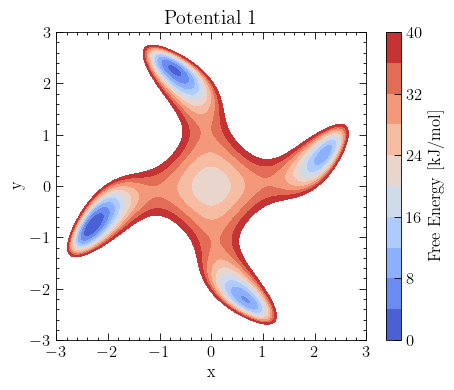

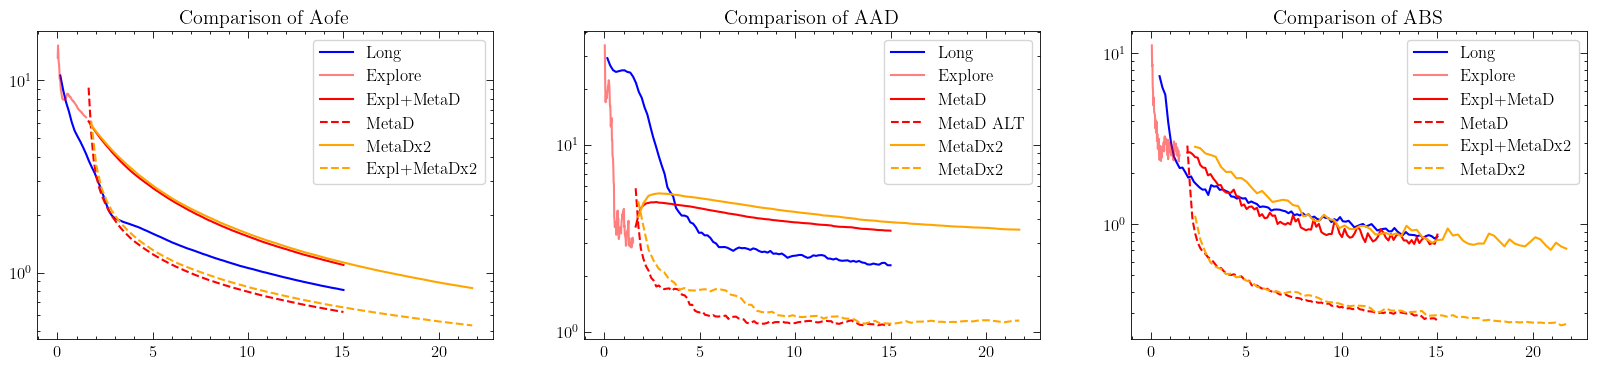

In [32]:
from scipy.signal import savgol_filter

def sf(data, window_length=None, polyorder=None):
    # if window_length is None: window_length = int(len(data)/10)
    # if polyorder is None: polyorder = 2
    # return savgol_filter(data, window_length, polyorder)
    return data

plt.figure(figsize=(5,4))
plt.contourf(X, Y, pot2, levels=np.linspace(0, 40, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Potential 1"); plt.show()


plt.figure(figsize=(20,4))
# time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad

plt.subplot(1,3,1)
plt.plot(time_long, mean_ofe_long, label="Long", color="blue")
plt.plot(t_expl, aofe_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, mean_ofe_metad, label="Expl+MetaD", color="red")
plt.plot(time_metadALT, mean_ofe_metadALT, label="MetaD", color="red", linestyle="--")
plt.plot(time_metadx2, mean_ofe_metadx2, label="MetaDx2", color="orange")
plt.plot(time_metadx2ALT, mean_ofe_metadx2ALT, label="Expl+MetaDx2", color="orange", linestyle="--")
# plt.plot(time_metadx3, mean_ofe_metadx3, label="MetaDx3", color="green")
# plt.plot(time_metadx4, mean_ofe_metadx4, label="MetaDx4", color="purple")
# plt.plot(time_metadx6, mean_ofe_metadx6, label="MetaDx6", color="aquamarine")
# plt.plot(time_metadx10, mean_ofe_metadx10, label="MetaDx6", color="grey")
plt.legend(); plt.yscale("log"); plt.title("Comparison of Aofe")

plt.subplot(1,3,2)
plt.plot(time_long, sf(mean_aad_long), label="Long", color="blue"); #plt.plot([t_long[-1],t1x4[-1]], [aad_long[-1],aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
# plt.plot(time_expl, mean_aad_expl, label="Explore", color="red", alpha=0.5)
plt.plot(t_expl, aad_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, sf(mean_aad_metad), label="MetaD", color="red");#plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3)
plt.plot(time_metadALT, sf(mean_aad_metadALT), label="MetaD ALT", color="red", linestyle="--");#plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3)
plt.plot(time_metadx2, sf(mean_aad_metadx2), label="MetaDx2", color="orange")
plt.plot(time_metadx2, sf(mean_aad_metadx2ALT), label="MetaDx2", color="orange", linestyle="--")
# plt.plot(time_metadx3, sf(mean_aad_metadx3), label="MetaDx3", color="green")
# plt.plot(time_metadx4, sf(mean_aad_metadx4), label="MetaDx4", color="purple")
# plt.plot(time_metadx6, sf(mean_aad_metadx6), label="MetaDx6", color="aquamarine")
# plt.plot(time_metadx10, sf(mean_aad_metadx10), label="MetaDx6", color="grey")
plt.legend(); plt.yscale("log"); plt.title("Comparison of AAD"); 
# plt.xlim(0,10)

plt.subplot(1,3,3)
plt.plot(time_long, sf(mean_abs_long), label="Long", color="blue"); #plt.plot([t_long[-1],t1x4[-1]], [aad_long[-1],aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
# plt.plot(time_expl, mean_aad_expl, label="Explore", color="red", alpha=0.5)
plt.plot(t_expl, abs_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, sf(mean_abs_metad), label="Expl+MetaD", color="red");#plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3)
plt.plot(time_metadALT, sf(mean_abs_metadALT), label="MetaD", color="red", linestyle="--");#plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3)
plt.plot(time_metadx2, sf(mean_abs_metadx2), label="Expl+MetaDx2", color="orange")
plt.plot(time_metadx2ALT, sf(mean_abs_metadx2ALT), label="MetaDx2", color="orange", linestyle="--")
# plt.plot(time_metadx3, sf(mean_aad_metadx3), label="MetaDx3", color="green")
# plt.plot(time_metadx4, sf(mean_aad_metadx4), label="MetaDx4", color="purple")
# plt.plot(time_metadx6, sf(mean_aad_metadx6), label="MetaDx6", color="aquamarine")
# plt.plot(time_metadx10, sf(mean_aad_metadx10), label="MetaDx6", color="grey")
plt.legend(); plt.yscale("log"); plt.title("Comparison of ABS"); 
# plt.ylim(0.38, 0.6)

plt.show()